# Event display of stable particles in 2D planes

Load the inclusive $Z^0 \to f \bar{f}$ MC:

In [606]:
import sys,os
import uproot4 as uproot
import awkward1 as ak
import json
import numpy as np
import matplotlib.pyplot as plt
from fcc_python_tools.locations import loc
from fcc_python_tools import kinematics
from particle import literals as lp
from fcc_python_tools import plotting
import random

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

file_types = {"ccbar": ["cc","$Z^0 \\to c \\bar{c}$"],
              "bbbar": ["bb","$Z^0 \\to b \\bar{b}$"],
              "qqbar": ["qq","$Z^0 \\to q \\bar{q}$"],
              "mumu": ["mumu","$Z^0 \\to \\mu^+ \\mu^-$"],
              "ee": ["ee","$Z^0 \\to e^+ e^-$"]
             }

#Choose the event type
file_type = "qqbar"

file = uproot.open(f"/eos/experiment/fcc/ee/tmp/ee_Z_{file_type}_EDM4Hep.root")
tree = file['events']

Get the generated particles and calculate their momenta:

In [607]:
#Get all the variables in the tree
vars = tree.keys()

#Loacation of the generated particles
r_container = "Particle"
r_c = f'{r_container}/{r_container}'

#Keep the variables that aren't covMatrix
keep_vars = []
for v in vars:
    if("covMatrix" not in v and r_c in v):
        keep_vars.append(v)

r = tree.arrays(keep_vars,how="zip")
r[r_c,'p'] = kinematics.calc_p(r,r_c)

Get a random event to plot:

In [608]:
#Nice charm events: 118, 588, 862
#Nice B events: 256
#Nice qqbar events: 419
rand = random.randint(0,999) 
r = r[r_c][rand] 
print(f"Random event: {rand}")

Random event: 419


Filter particles which have `generatorStatus == 1`, which in `Pythia` means final-state particle:

In [609]:
r_0 = r[r["generatorStatus"]==1]
n_parts = len(r_0)

Load the reconstructed vertices from LCIO for the particular $Z^0 \to f \bar{f}$ sample:

In [610]:
if(file_type in ["qqbar","ccbar","bbbar"]):
    with open(f"/eos/experiment/fcc/ee/tmp/Output-vtx_{file_types[file_type][0]}_test.json","r") as f_vtx:
        vtx_dict = json.load(f_vtx)

Plot the particle directions from their birth vertex using the `quiver` function in `matplotlib`:

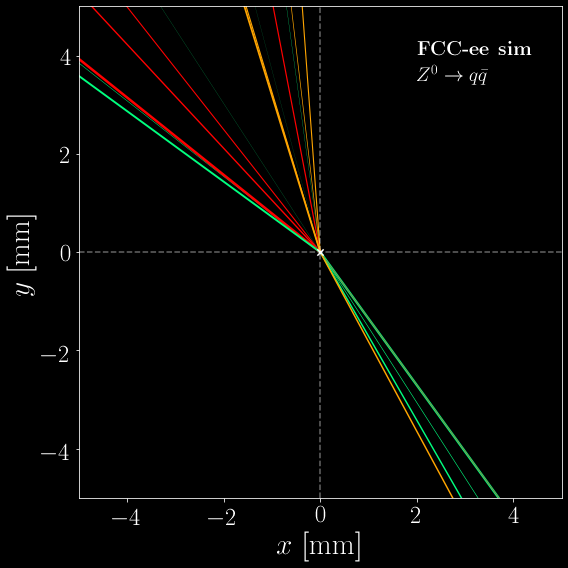

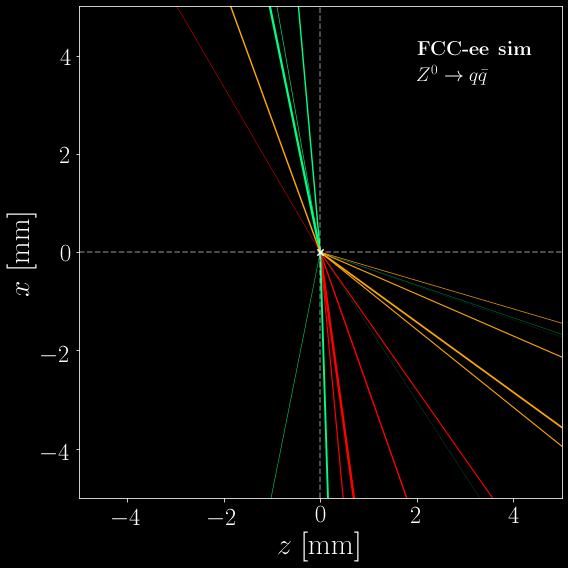

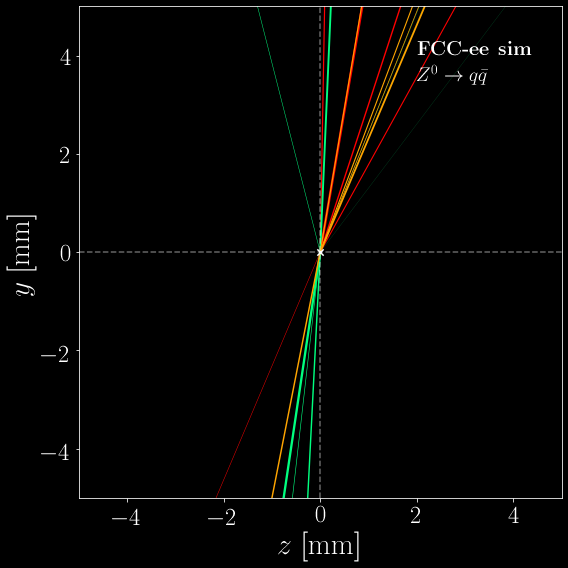

In [611]:
#2D decay planes
planes = {"xy": ["x","y"],
          "zx": ["z","x"],
          "zy": ["z","y"]
         }

#Different stable particles and their colours
colors = {"dodgerblue": lp.mu_plus.pdgid,
          "turquoise": lp.e_plus.pdgid,
          "orange": lp.gamma.pdgid,
          "springgreen": lp.pi_plus.pdgid,
          "red": lp.K_plus.pdgid,
          "magenta": lp.p.pdgid
         }

#Plot dimensions [mm]
plot_size = 5.

#Loop over the decay planes
for plane in planes:

    fig, ax = plt.subplots(figsize=(8,8))
    
    #Loop over particles in the event
    for i in range(0,n_parts):
        
        #Assign colour based on PDG ID, and only plot the particle if it is in the list above
        plot = False
        for c in colors:
            if(abs(r_0["PDG"][i]) == abs(colors[c])):
                color = c
                plot = True
         
        if(plot==True):
            #Ignore particles with exactly zero momentum components, to avoid errors with arctan
            if(r_0[f"momentum.{planes[plane][0]}"][i] != 0 and r_0[f"momentum.{planes[plane][1]}"][i]):
            
                #Location of particle production
                origin_vertex = [r_0[f"vertex.{planes[plane][0]}"][i], r_0[f"vertex.{planes[plane][1]}"][i]]
            
                #Don't plot very highly displaced vertices
                if(abs(origin_vertex[0]) < 10 and abs(origin_vertex[1]) < 10):
            
                    V = np.array([[r_0[f"momentum.{planes[plane][0]}"][i], r_0[f"momentum.{planes[plane][1]}"][i]]])
                    origin = [origin_vertex[0]], [origin_vertex[1]]
                
                    line_width = np.log(r_0["p"][i])/400.
                
                    plt.quiver(*origin, V[:,0], V[:,1], color=color, scale=0.0001, width=line_width)
    
    #Plot the reco vertices for quark events
    if(file_type in ["qqbar","ccbar","bbbar"]):
        for v in vtx_dict[f"{rand}"]:
            plt.scatter(v[planes[plane][0]], v[planes[plane][1]], s=40, color='white', marker="x")
                    
    ax.tick_params(axis='both', which='major', labelsize=25)
    plt.xlabel(f"${planes[plane][0]}$ [mm]",fontsize=30)
    plt.ylabel(f"${planes[plane][1]}$ [mm]",fontsize=30)
    plt.axvline(x=0,color='white',linestyle='--',alpha=0.4)
    plt.axhline(y=0,color='white',linestyle='--',alpha=0.4)
    plt.style.use('dark_background')
    plt.xlim(-plot_size,plot_size)
    plt.ylim(-plot_size,plot_size)
    plt.text(0.4*plot_size,0.8*plot_size,"\\textbf{FCC-ee sim}",fontsize=20)
    plt.text(0.4*plot_size,0.7*plot_size,file_types[file_type][1],fontsize=20)
    plt.tight_layout()
    plt.show()
    fig.savefig(f"{loc.PLOTS}/event_display_{planes[plane][0]}_{planes[plane][1]}_Z2{file_type}_event_{rand}.pdf")